In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde, wasserstein_distance_nd
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

import graphics

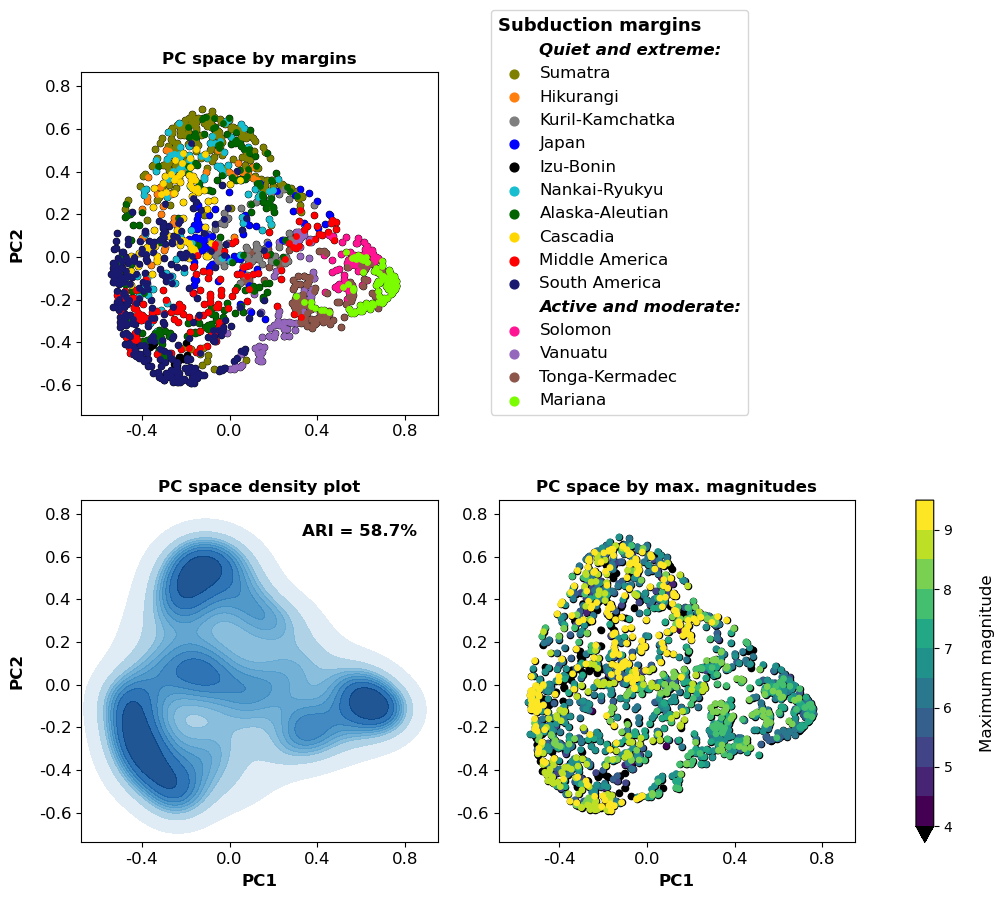

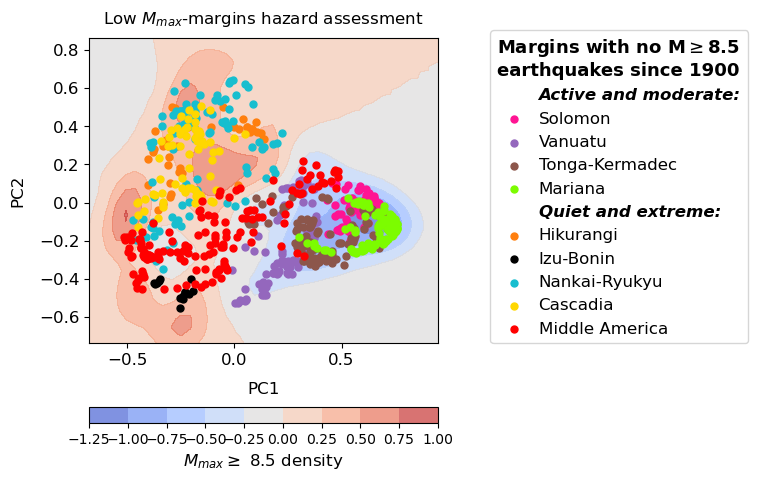

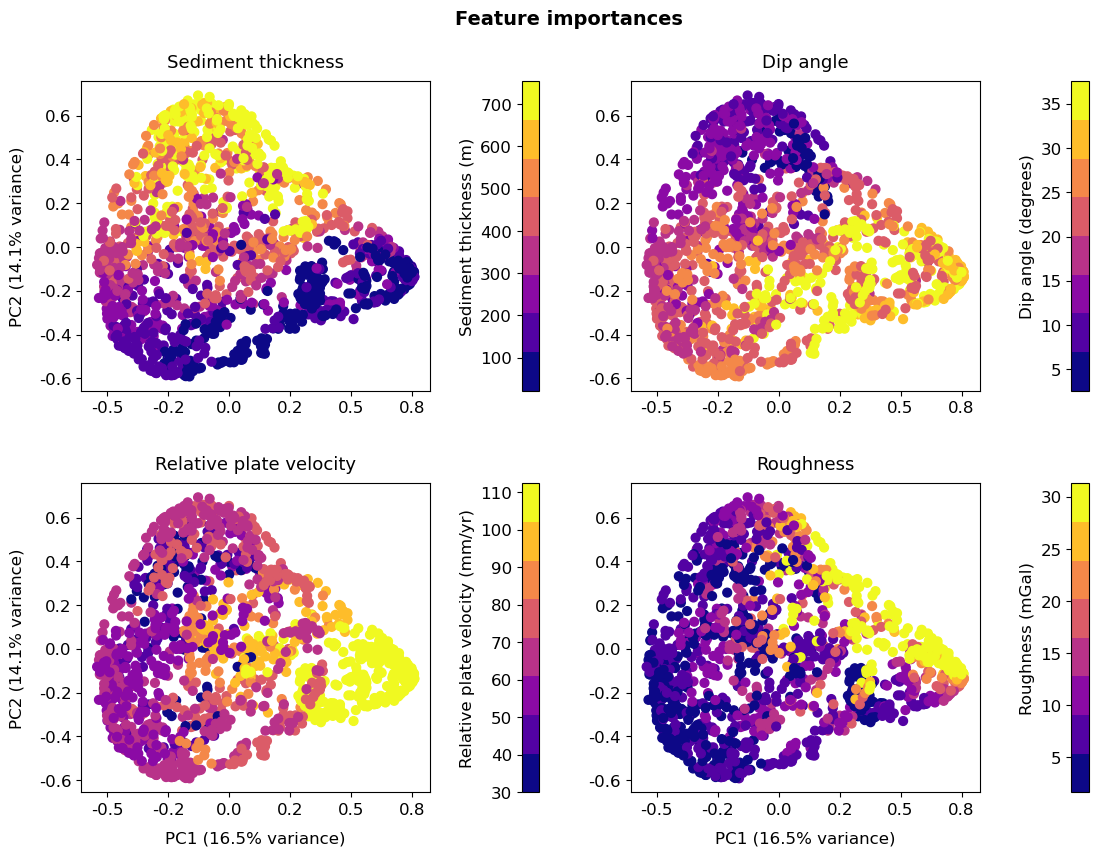

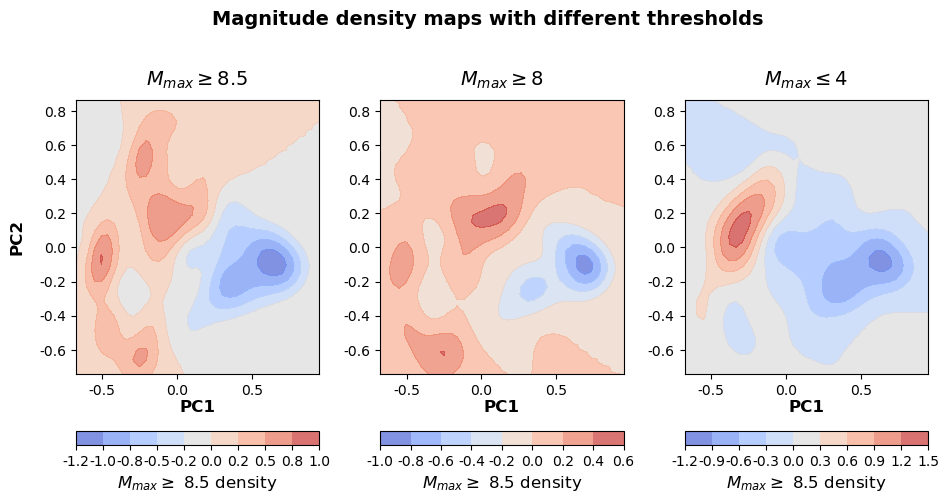

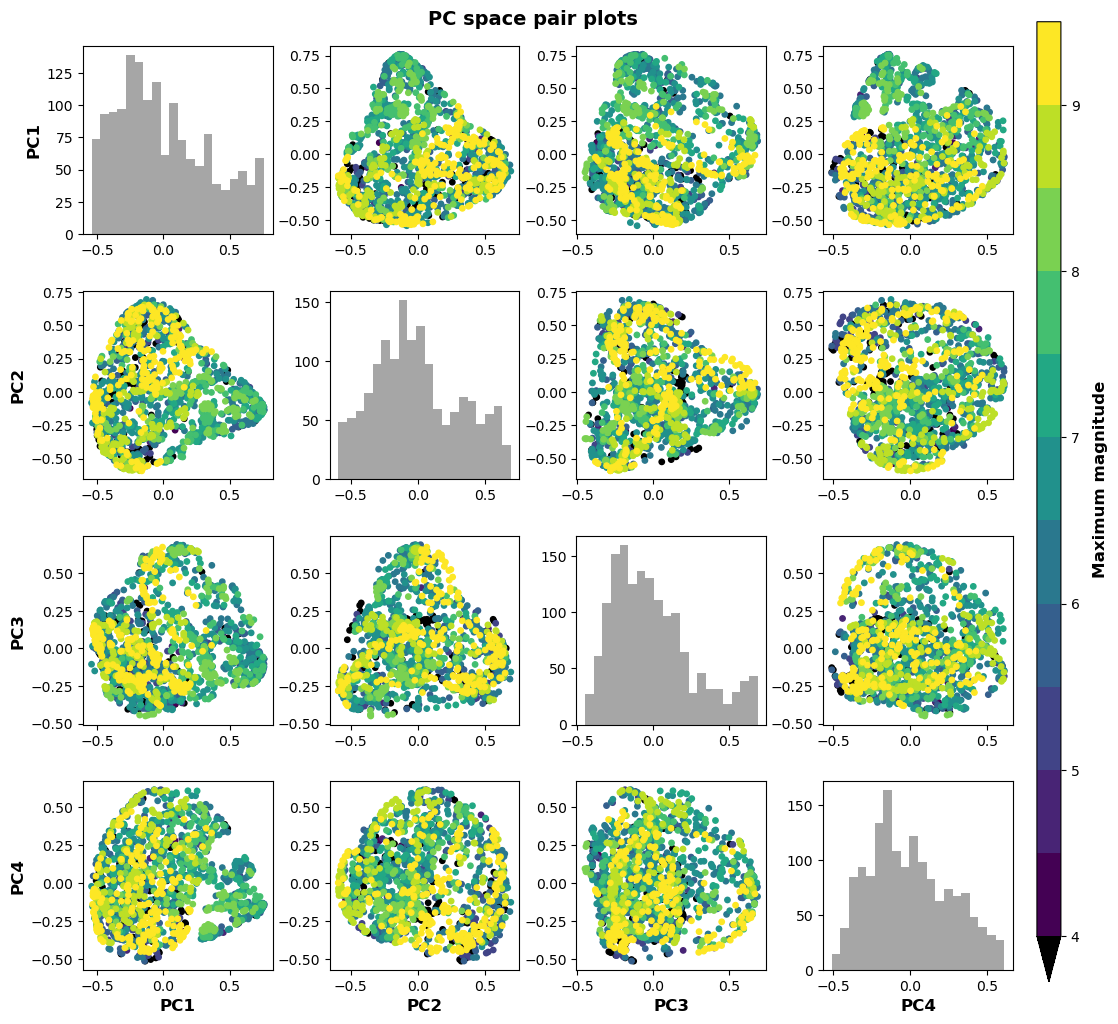

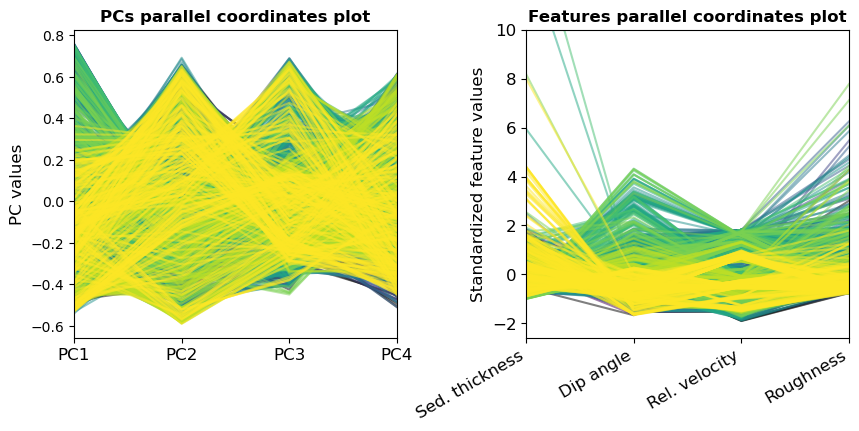

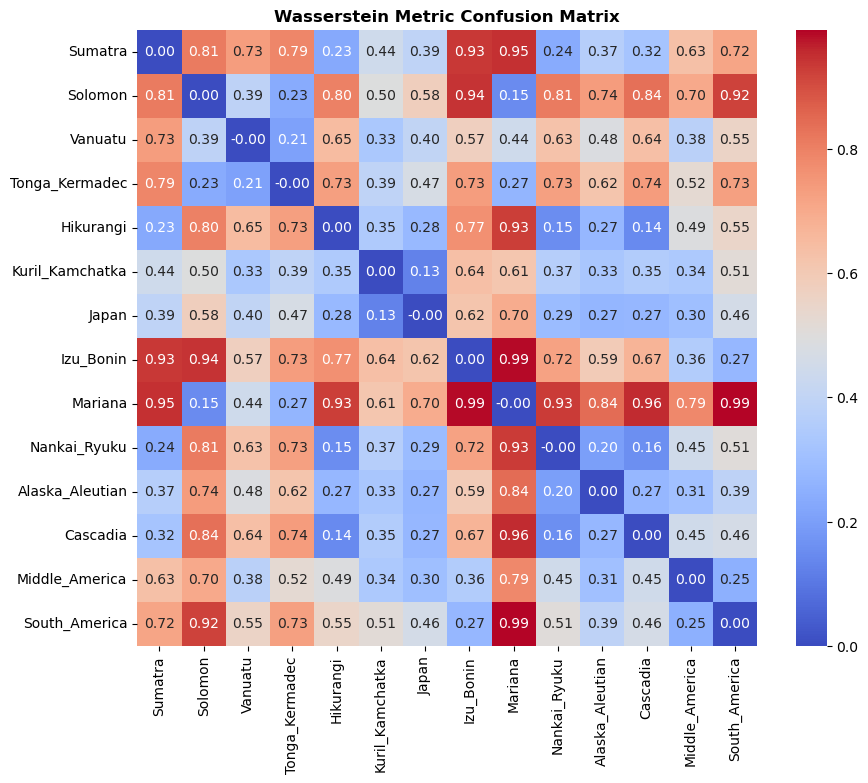

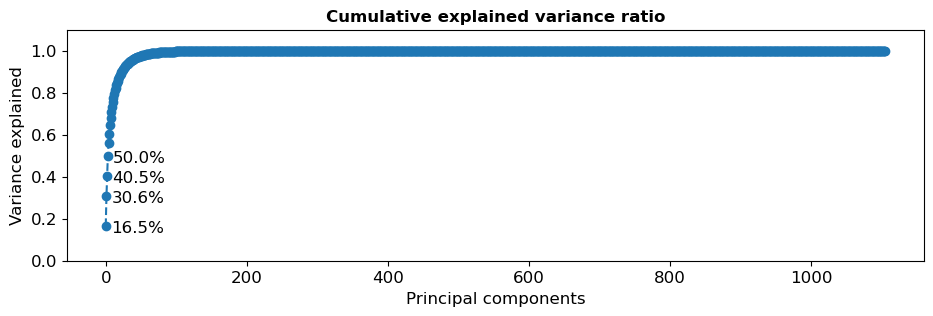

/home/val22/miniconda3/envs/dsml4pe/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


FeatureUnion(transformer_list=[('Feature processing',
                                ColumnTransformer(remainder='passthrough',
                                                  transformers=[('Imputer',
                                                                 SimpleImputer(),
                                                                 ['Sed_Thick',
                                                                  'Dip', 'Vel',
                                                                  'Rough'])])),
                               ('PCA projection',
                                Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(transformers=[('Log. '
                                                                                  'Preprocessor',
                                                                                  Pipeline(steps=[('Imputer',
                                                                                                   SimpleImputer()),
                                                                                                  ('Log '
                                                                                                   'Transform',
                                                                                                   LogTransformer()),
                                                                                                  ('Scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Sed_Thick',
                                                                                   'Dip',
                                                                                   'Rough']),
                                                                                 ('Preprocessor',
                                                                                  Pipeline(steps=[('Imputer',
                                                                                                   SimpleImputer()),
                                                                                                  ('Scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['Vel'])])),
                                                ('PCA',
                                                 KernelPCA(kernel='rbf',
                                                           n_components=4,
                                                           random_state=42))]))])

In [2]:
from Projector import Projector

scaler = 'StandardScaler'
kernel = 'rbf' 
gamma = None

params = {'scaler': scaler, 'kernel': kernel, 'gamma': gamma}
features = ['Sed_Thick', 'Dip', 'Vel', 'Rough']

projector = Projector(params=params, features=features, threshold = 8, generate_figures=True)
projector.get_projector()

In [84]:
class FigureMaker():
    
    def __init__(self, projector):

        self.data = projector.data_projected
        self.xmin, self.xmax = self.data.PC1.min()*1.25, self.data.PC1.max()*1.25
        self.ymin, self.ymax = self.data.PC2.min()*1.25, self.data.PC2.max()*1.25

        self.all_features = projector.all_features
        self.var = projector.cumulative_explained_variance_ratio
        self.ari = projector.ari 

        self.zones, self.zone_color_dict, self.zone_label_dict, self.subtitle_dict = graphics.get_zone_dicts()
        self.feature_dict, self.unit_dict = graphics.get_feature_dicts()
        self.cmap, self.norm = graphics.get_mag_cmap()
        self.fontsize=12

        self.pc_space_summary()
        self.plot_hazard_assessment()
        self.feature_importance_plots()
        self.different_heatmaps()
        self.plot_pca_pairplot()
        self.parallel_coords_figure()
        self.create_confusion_matrix()
        self.variance_plot()
        
    
    def pc_space_summary(self):
        
        fig,ax = plt.subplots(2,3, figsize = (11,10), gridspec_kw={"width_ratios":[1, 1, 0.05]})
        fig.subplots_adjust(wspace = 0.25, hspace = 0.25)

        fig.delaxes(ax[0,1])
        fig.delaxes(ax[0,2])

        # scatter margins
        ax[0,0].scatter(self.data.PC1, self.data.PC2, c = 'k', s = 20)
        scatter_handles = self.plot_margins(self.data, ax[0,0], s=15)

        # density plots
        sns.kdeplot(x=self.data['PC1'], y=self.data['PC2'], ax=ax[1,0], fill=True, cmap='Blues', alpha = 0.9)
        ax[1,0].set_xlabel(' ') # remove automatically generated axis labels
        ax[1,0].set_ylabel(' ')
        ax[1,0].text(0.33, 0.7, f'ARI = {np.round(100*self.ari, 1)}%', fontsize=self.fontsize, weight = 'bold')

        # max. mag. plots
        ax[1,1].scatter(self.data.PC1, self.data.PC2, c = 'k', s = 20)

        data_sorted = self.data.sort_values(by = 'Max_mag', ascending = True)
        magnitudes = ax[1,1].scatter(data_sorted.PC1, data_sorted.PC2, c = data_sorted.Max_mag, s = 15, \
                                     cmap=self.cmap, vmin = 4, vmax = 9.5)
        magnitudes.cmap.set_under('k') 

        # magnitude colourbar
        cbar = plt.colorbar(magnitudes, cax=ax[1,2], orientation='vertical', extend = 'min')
        cbar.set_label(label = 'Maximum magnitude', fontsize=self.fontsize, labelpad = 20)

        lgnd = graphics.create_custom_legend(ax[0,0], scatter_handles, fontsize=self.fontsize, legend_loc = (1.15, 0))
        lgnd.set_title('Subduction margins', prop={'size':self.fontsize+1, 'weight':'bold'})

        for i in range(16):
            try:
                lgnd.legendHandles[i]._sizes = [40]
            except IndexError:
                pass

        # set titles
        ax[0,0].set_title('PC space by margins', fontsize=self.fontsize, weight='bold')
        ax[1,0].set_title('PC space density plot', fontsize=self.fontsize, weight='bold')
        ax[1,1].set_title('PC space by max. magnitudes', fontsize=self.fontsize, weight='bold')


        # set same axis extents
        for j in range(2):
            for i in range(2):
                ax[i,j].set_xlim([self.xmin, self.xmax])
                ax[i,j].set_ylim([self.ymin, self.ymax])

        # axes and tick labels
        for k in range(2): 
            ax[k,0].set_ylabel('PC2', fontsize=self.fontsize, weight = 'bold', labelpad = 10) # y labels
            ax[1,k].set_xlabel('PC1', fontsize=self.fontsize, weight = 'bold', labelpad = 5) # x labels

        for i in range(2): # ticks on plots + mag. colourbar
            for j in range(2): 
                ax[i,j].tick_params(axis='both', which='major', labelsize=self.fontsize) 
                ax[i,j].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax[i,j].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) 

        plt.show()
        
        
    def plot_hazard_assessment(self):
        
        fig,[ax,cax] = plt.subplots(2,1, figsize = (4.5,5), gridspec_kw={"height_ratios":[1,0.05]})
        fig.subplots_adjust(hspace=0.4)

        h = self.heatmap(ax, cax, mag_range=[8.5,10])
        scatter_handles = self.plot_margins(graphics.get_low_margin_data(self.data), ax)
        
        lgnd = graphics.create_custom_legend(ax, scatter_handles, fontsize=self.fontsize, legend_loc = (1.15, 0))
        lgnd.set_title('Margins with no M$\geq$8.5 \nearthquakes since 1900', prop={'size':self.fontsize+1, 'weight':'bold'})

        ax.set_title('Low $M_{max}$-margins hazard assessment', fontsize=self.fontsize, pad = 10)
        ax.set_xlabel('PC1', fontsize=self.fontsize, labelpad = 10)
        ax.set_ylabel('PC2', fontsize=self.fontsize, labelpad = 10)
        ax.tick_params(axis='both', which='major', labelsize=self.fontsize)

        plt.show()
        
        
    def feature_importance_plots(self):
        
        fig,ax = plt.subplots(2,4, figsize = (13,9), gridspec_kw={"width_ratios":[1, 0.05, 1, 0.05]})
        fig.subplots_adjust(wspace = 0.5, hspace = 0.3, top = 0.9)
        fig.suptitle('Feature importances', fontsize=self.fontsize+2, weight='bold')

        axes = [ax[0,0], ax[0,2], ax[1,0], ax[1,2]]
        cbars = [ax[0,1], ax[0,3], ax[1,1], ax[1,3]]

        for i in range(4): 

            # colorbar extent: (to avoid extremes/outliers influencing colorbar)
            vmin, vmax = self.data[self.all_features[i]].min(), np.percentile(self.data[self.all_features[i]], 90)

            # scatter data points: 
            axes[i].scatter(self.data['PC1'], self.data['PC2'], s = 60, c = 'white')
            feature_plot = axes[i].scatter(self.data['PC1'], self.data['PC2'], s = 40, c = self.data[self.all_features[i]], \
                                           cmap = mpl.cm.get_cmap('plasma', 8), vmin=vmin, vmax=vmax)

            # colorbar: 
            cbar = fig.colorbar(feature_plot, cax=cbars[i])
            cbar.set_label(label=f'{self.feature_dict[self.all_features[i]]} ({self.unit_dict[self.all_features[i]]})', \
                           fontsize = self.fontsize)
            cbar.ax.tick_params(labelsize=self.fontsize)
            cbar.ax.yaxis.set_label_position('left')
            cbar.ax.yaxis.set_ticks_position('left')

            # titles: 
            axes[i].set_title(f'{self.feature_dict[self.all_features[i]]}', fontsize=self.fontsize+1, pad=10)

        # axes labels + ticks
        ax[0,0].set_ylabel(f'PC2 ({np.round(100*(self.var[1]-self.var[0]), 1)}% variance)', fontsize=self.fontsize, labelpad=10)
        ax[1,0].set_ylabel(f'PC2 ({np.round(100*(self.var[1]-self.var[0]), 1)}% variance)', fontsize=self.fontsize, labelpad=10)
        ax[1,0].set_xlabel(f'PC1 ({np.round(100*(self.var[0]), 1)}% variance)', fontsize=self.fontsize, labelpad=10)
        ax[1,2].set_xlabel(f'PC1 ({np.round(100*(self.var[0]), 1)}% variance)', fontsize=self.fontsize, labelpad=10)

        for ax in axes + cbars:
            ax.tick_params(axis='both', which='major', labelsize=self.fontsize)

        for ax in axes:
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

        plt.show()
        
        
    def different_heatmaps(self):
        
        fig,ax = plt.subplots(2,3, figsize = (11,5), gridspec_kw={"height_ratios":[1, 0.05]})
        fig.subplots_adjust(wspace = 0.25, hspace = 0.4, top = 0.8)
        fig.suptitle('Magnitude density maps with different thresholds', fontsize=self.fontsize+2, weight='bold')

        self.heatmap(ax=ax[0,0], cax=ax[1,0], mag_range=[8.5, 10])
        self.heatmap(ax=ax[0,1], cax=ax[1,1], mag_range=[8, 10])
        self.heatmap(ax=ax[0,2], cax=ax[1,2], mag_range=[0, 4])

        titles = ['$M_{max} \geq 8.5$', '$M_{max} \geq 8$', '$M_{max} \leq 4$']

        for i in range(3):
            ax[0,i].set_xlabel('PC1', fontsize=self.fontsize, labelpad = 2, weight = 'bold')
            ax[0,i].set_title(titles[i], fontsize = self.fontsize+2, weight = 'bold', pad=10)

            for j in range(2):
                ax[j,i].tick_params(axis='both', which='major', labelsize=self.fontsize-2) 
                ax[j,i].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
                ax[j,i].xaxis.set_major_formatter(FormatStrFormatter('%.1f')) 

        ax[0,0].set_ylabel('PC2', fontsize=self.fontsize, labelpad = 10, weight = 'bold')

        plt.show()
        
        
    def plot_pca_pairplot(self):
        
        data = self.data.sort_values(by='Max_mag', ascending=True)
        pc_columns=['PC1', 'PC2', 'PC3', 'PC4']    

        fig, ax = plt.subplots(4, 4, figsize=(12, 12), sharex=False, sharey=False)
        fig.subplots_adjust(hspace=0.3, wspace = 0.3, right=0.9)
        fig.suptitle('PC space pair plots', fontsize=self.fontsize+2, fontweight='bold', y=0.91)

        for i in range(4):
            for j in range(4):
                axis = ax[i, j]
                if i == j:
                    axis.hist(data[pc_columns[i]], bins=20, color='gray', alpha=0.7) # histogram on diagonal
                else: 
                    scatter = axis.scatter(data[pc_columns[j]], data[pc_columns[i]], c=data['Max_mag'], \
                                         cmap=self.cmap, norm=self.norm, s=15) # scatter plots 

                # axis labels
                if i == 3:
                    axis.set_xlabel(pc_columns[j], weight='bold', fontsize=self.fontsize) 
                if j == 0:
                    axis.set_ylabel(pc_columns[i], weight='bold', fontsize=self.fontsize)

        # colourbar
        cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) 
        cbar = fig.colorbar(scatter, cax=cbar_ax, extend = 'min')
        cbar.set_label('Maximum magnitude', fontsize = self.fontsize, weight='bold', labelpad= 10)
        
        plt.show()
        
        
    def parallel_coords_figure(self):
        
        fig,ax = plt.subplots(1,2, figsize = (10,4))
        fig.subplots_adjust(wspace = 0.4)

        self.parallel_coordinates_pc(ax[0])
        self.parallel_coordinates_ft(ax[1])

        plt.show()
        
        
    def create_confusion_matrix(self):

        w_distances = np.zeros((len(self.zones), len(self.zones))) # initialize matrix to store distances

        # loop through zones to calculate the distance for each pair of zones 
        for i, zone1 in enumerate(self.zones):
            for j, zone2 in enumerate(self.zones):
                w_distances[i, j] = self.calculate_wasserstein_metric(zone1, zone2)

        w_distances_df = pd.DataFrame(w_distances, index=self.zones, columns=self.zones)

        # plot confusion matrix as a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(w_distances_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
        plt.title(f'Wasserstein Metric Confusion Matrix', weight='bold')
        
        plt.show()
    
    def variance_plot(self):
        fig,ax = plt.subplots(1,1, figsize = (len(self.var)/100,3))

        ax.plot(np.arange(len(self.var)), self.var, '--o')

        ax.set_ylim([0,1.1])
        ax.set_xlabel('Principal components', fontsize=self.fontsize)
        ax.set_ylabel('Variance explained', fontsize=self.fontsize)
        ax.set_title('Cumulative explained variance ratio', weight='bold', fontsize=self.fontsize) 
        ax.tick_params(axis='both', which='major', labelsize=self.fontsize)

        for i in range(4): # annotate explained variance for four first PCs 
            text_location = (i+7, self.var[i]-.03)
            ax.annotate(f'{np.round(100*self.var[i],1)}%', text_location, fontsize=self.fontsize)

        plt.show()
    
    
    def plot_margins(self, data, ax, s=25): 

        scatter_handles = {} # store scatter plots in groups based on subtitles

        for zone in self.zones:
            if zone in data.Sub_Zone.unique():
                zonedata = data[data.Sub_Zone == zone]
                scatter = ax.scatter(zonedata.PC1, zonedata.PC2, c=self.zone_color_dict[zone], s=s, \
                                     label=self.zone_label_dict[zone])
                
                subtitle = self.subtitle_dict.get(zone) # assign scatter to subtitle
                if subtitle not in scatter_handles:
                    scatter_handles[subtitle] = []
                    
                scatter_handles[subtitle].append(scatter)
                
            else:
                pass

        return scatter_handles


    def heatmap(self, ax, cax, mag_range = [8.5,10]):

        # calculate overall density in the PC space
        x1, y1 = np.array(self.data.PC1, dtype = float), np.array(self.data.PC2, dtype = float)
        xi, yi = np.mgrid[self.xmin:self.xmax:x1.size**0.5*1j, self.ymin:self.ymax:y1.size**0.5*1j]
        k1 = gaussian_kde(np.vstack([x1, y1]))
        zi1 = k1(np.vstack([xi.flatten(), yi.flatten()]))

        # calculate density of M8.5+ earthquakes in the PC space
        heatmap_data = self.data[(self.data.Max_mag >= mag_range[0]) & (self.data.Max_mag <= mag_range[1])]
        x2, y2 = np.array(heatmap_data.PC1, dtype = float), np.array(heatmap_data.PC2, dtype = float)
        k2 = gaussian_kde(np.vstack([x2, y2]))
        zi2 = k2(np.vstack([xi.flatten(), yi.flatten()]))

        zi = zi2-zi1

        heatmap = ax.contourf(xi, yi, zi.reshape(xi.shape), cmap = 'coolwarm', alpha = 0.7)

        cbar = plt.colorbar(heatmap, cax=cax, orientation='horizontal')
        cbar.set_label(label = '$M_{max} \geq$ 8.5 density', fontsize=self.fontsize)

        return heatmap
    
    
    def parallel_coordinates_pc(self, ax):
        
        data = self.data.sort_values(by = 'Max_mag', ascending=True, inplace=False) # sort the data by maximum magnitude for better visualization

        for idx in range(len(data)): # plotting parallel coordinates line for each data point 
            row = data[['PC1', 'PC2', 'PC3', 'PC4']].iloc[idx].values
            color_value = data['Max_mag'].iloc[idx]
            ax.plot(range(4), row, color=self.cmap(self.norm(color_value)), alpha=0.5)

        # axis ticks and labels
        ax.set_xticks(range(4))
        ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4'], fontsize=self.fontsize)
        ax.set_xlim([0, 3])
        ax.set_ylabel('PC values', fontsize=self.fontsize) 

        ax.set_title('PCs parallel coordinates plot', weight='bold', fontsize=self.fontsize)


    def parallel_coordinates_ft(self, ax):

        # create a dataframe with standardized features and maximum magnitude
        scaler = StandardScaler()
        standardized_data = pd.DataFrame(scaler.fit_transform(self.data[self.all_features]), columns=self.all_features)
        standardized_data['Max_mag'] = self.data['Max_mag'].values

        # sort the data by maximum magnitude for better visualization
        standardized_data = standardized_data.sort_values(by='Max_mag', ascending=True)

        for idx in range(len(standardized_data)): # plotting parallel coordinates line for each data point 
            row = standardized_data.iloc[idx][self.all_features].values
            color_value = standardized_data['Max_mag'].iloc[idx]
            ax.plot(range(4), row, color=self.cmap(self.norm(color_value)), alpha=0.5)

        # axis ticks and labels
        ax.set_xticks(range(4))
        xlabels = ['Sed. thickness', 'Dip angle', 'Rel. velocity', 'Roughness']
        ax.set_xticklabels(xlabels, rotation=30, ha='right', fontsize=self.fontsize)  # Rotate labels by 30 degrees
        ax.set_xlim([0, 3])

        ax.set_ylim([-2.6, 10])
        ax.set_ylabel('Standardized feature values', fontsize=self.fontsize)

        ax.tick_params(axis='both', which='major', labelsize=self.fontsize)

        ax.set_title('Features parallel coordinates plot', weight='bold', fontsize=self.fontsize)

        
    def calculate_wasserstein_metric(self, zone1, zone2):
        
        array1 = np.array(self.data[self.data.Sub_Zone == zone1][['PC1', 'PC2']])
        array2 = np.array(self.data[self.data.Sub_Zone == zone2][['PC1', 'PC2']])
        
        return wasserstein_distance_nd(array1, array2)

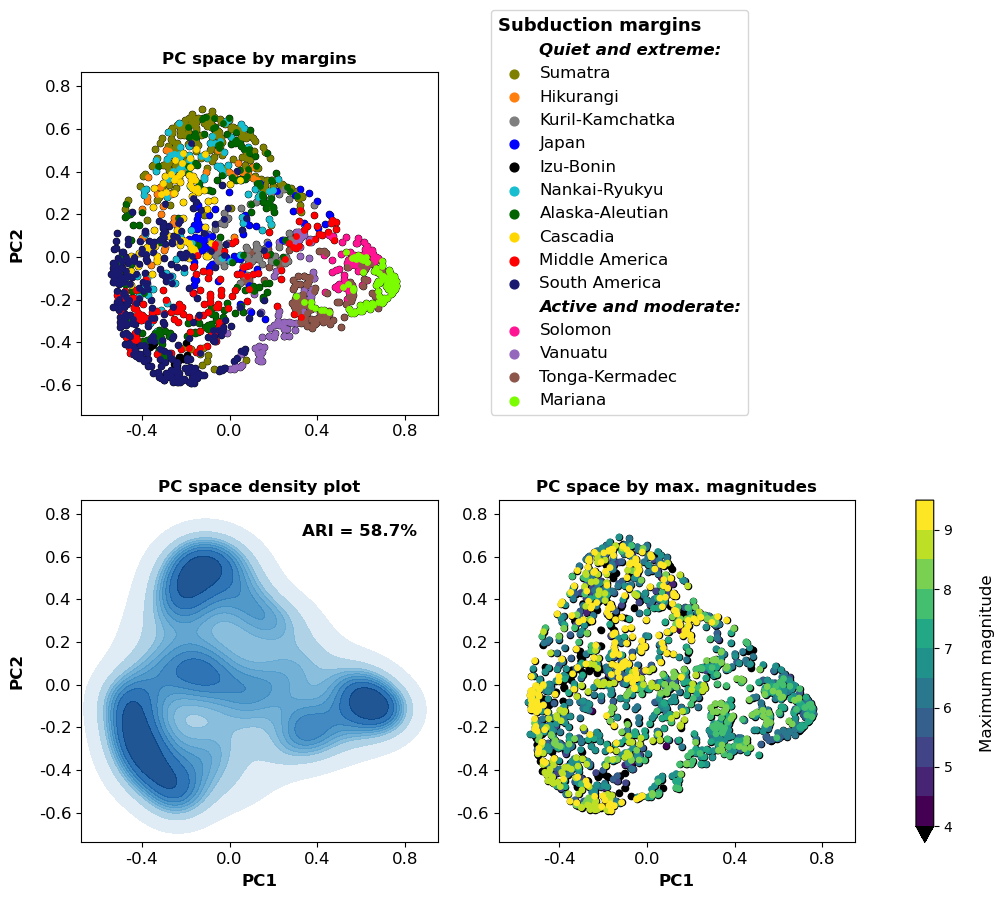

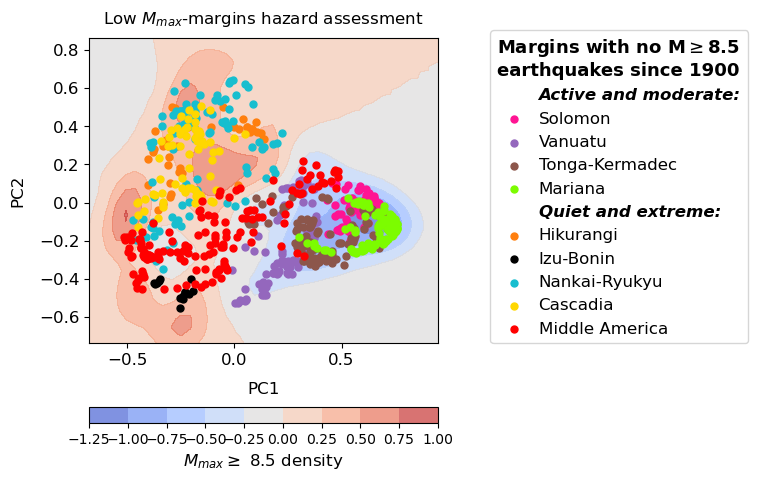

In [85]:
FigureMaker(projector)